# 🎬 Streaming Wars: Dados, Estratégias e Pipoca  
### Como Netflix, Prime Video, HBO Max e Apple TV+ Disputam Seu Tempo (e Seu Bolso)!

## 🎯 Objetivo

Analisar padrões de conteúdo, popularidade e estratégias de catálogo das principais plataformas de streaming:

- **Netflix**
- **HBO Max**
- **Apple TV+**
- **Prime Video**

O foco está em entender como cada serviço organiza seu catálogo, quais títulos fazem mais sucesso e quais são as estratégias adotadas para conquistar e reter assinantes.

---

*Mas antes de mais nada, um pequeno intervalo para ressalvas:*

**Estratégia de EDA no Projeto de Streaming**

A análise exploratória dos dados (EDA) do projeto foi conduzida de forma  incremental, sempre buscando entender as limitações dos dados e as melhores formas de tratá-los, mesmo reconhecendo que algumas escolhas podem ser revistas no futuro. Segue um resumo das etapas adotadas, que podem ser conferidas de forma integral nos notebooks de análise exploratória individuais para cada streaming e presentes na arvore de diretórios desse projeto:

1. **Carregamento e Inspeção Inicial**
    
    Os dados foram lidos com pandas e fiz uma primeira exploração básica: tipos, estatísticas simples, busca por nulos e duplicatas. Nem sempre foi possível identificar todos os problemas logo de cara.
    
2. **Tratamento de Dados Faltantes e Duplicados**
    
    Removi duplicatas e tentei preencher valores ausentes nas colunas mais importantes, como genres e imdbId. Em algumas situações, tive que tomar decisões baseadas no que parecia mais razoável, mesmo sabendo que não existe solução perfeita para todos os casos. A sensação de estar picotando o notebook estava ali. 🫠
    
3. **Imputação de Valores**
    
    Para ratings e número de votos ausentes, usei medianas por gênero e década, ou globalmente quando necessário. Reconheço que esse método é simples e pode não capturar toda a nuance dos dados, mas foi uma escolha pragmática diante das limitações.
    
4. **Conversão e Padronização de Tipos**
    
    Convertendo colunas para tipos adequados e removendo colunas auxiliares, tentei deixar o dataset mais limpo, mas sempre atentei ao risco de perder informações relevantes.
    
5. **Criação de Dataset Limpo**
    
    Selecionei apenas as colunas essenciais para análise e fiz uma checagem final de nulos e tipos. Admito que a definição do que é “essencial” pode variar conforme o objetivo da análise.
    
6. **Exploração de Variáveis-Chave**
    
    Analisei os tipos de conteúdo e gêneros, extraindo informações de strings compostas. A identificação dos gêneros mais populares foi feita de modo descritivo, reconhecendo possíveis vieses nos dados originais.
    
7. **Documentação e Salvamento**
    
    Registrei exemplos e estatísticas para validar os tratamentos. O salvamento do dataset limpo foi feito para facilitar análises futuras, mas bem sei que ajustes podem ser necessários conforme novas demandas surgirem. Principalmente tendo em vista que quero prosseguir nesse projeto para uma aplicação no Streamlit que promova recomendações com base nos gêneros de interesse e últimos títulos que o usuário assistiu
    

É isso! Feitas as ressalvas do EDA, seguimos para o Streaming Wars!

---

### Instalação e Importação das Bibliotecas

Utilizaremos as principais bibliotecas de ciência de dados em Python:

- **pandas**: análise de dados
- **numpy**: operações numéricas
- **matplotlib** e **seaborn**: visualização de dados
- **collections.Counter**: contagem eficiente de elementos

A instalação é feita com `%pip install` e as bibliotecas são importadas para uso no notebook.


In [38]:
"""%pip install pandas
%pip install numpy 
%pip install matplotlib
%pip install seaborn"""

'%pip install pandas\n%pip install numpy \n%pip install matplotlib\n%pip install seaborn'

In [39]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

---

### Configuração Visual para Matplotlib e Seaborn

Para garantir que os gráficos fiquem mais claros, bonitos e padronizados ao longo do notebook, é importante configurar alguns parâmetros visuais das bibliotecas de visualização:

- **Estilo do Matplotlib:** O comando `plt.style.use('default')` define um estilo visual básico e limpo para todos os gráficos.
- **Paleta de Cores do Seaborn:** `sns.set_palette("husl")` aplica uma paleta de cores vibrante e diferenciada, facilitando a distinção entre categorias.
- **Tamanho Padrão das Figuras:** `plt.rcParams['figure.figsize'] = (12, 8)` define um tamanho padrão maior para os gráficos, melhorando a visualização dos detalhes.

Essas configurações tornam as visualizações mais profissionais e facilitam a análise dos dados apresentados.

In [40]:
# Configuração visual
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

---

### Carregamento dos Dados das Plataformas

Nesta célula, são carregados os arquivos CSV já tratados de cada plataforma de streaming (Netflix, HBO Max, Apple TV+ e Prime Video) utilizando o `pandas`. 
Cada dataset é lido separadamente, permitindo a análise individual e posterior unificação dos dados. 
Ao final, é exibida a quantidade de registros (títulos) disponíveis em cada plataforma, facilitando a comparação inicial do volume de conteúdo entre elas.

In [41]:
# Carregar cada CSV limpo
df_netflix = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/data_netflix_clean.csv')
df_hbo = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/data_hbo_clean.csv')
df_apple = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/df_apple_clean.csv')
df_prime = pd.read_csv('C:/Users/nise_/OneDrive/Documentos/Digital College/Python/DA_18/streaming/Dados_tratados/data_prime_video_clean.csv')


print("📂 DATASETS CARREGADOS:")
print(f"Netflix: {len(df_netflix):,} registros")
print(f"HBO Max: {len(df_hbo):,} registros") 
print(f"Apple TV: {len(df_apple):,} registros")
print(f"Prime Video: {len(df_prime):,} registros")

📂 DATASETS CARREGADOS:
Netflix: 21,391 registros
HBO Max: 9,776 registros
Apple TV: 18,692 registros
Prime Video: 72,943 registros


---

### Adicionando a Coluna de Plataforma

Para realizar análises comparativas entre os catálogos das diferentes plataformas de streaming, é fundamental identificar de qual serviço cada título faz parte. Por isso, após carregar os dados individuais de cada plataforma, adicionamos uma coluna chamada `platform` em cada DataFrame.

**Como funciona:**

-  **DataFrames individuais:**  
    - `df_netflix`
    - `df_hbo`
    - `df_apple`
    - `df_prime`

-  **Adição da coluna `platform`:**  
    Cada DataFrame recebe uma nova coluna chamada `platform` com o nome da respectiva plataforma como valor fixo para todos os registros.

-  **Exemplo:**  
    | title           | ... | platform   |
    |-----------------|-----|------------|
    | Forrest Gump    | ... | Netflix    |
    | Forrest Gump    | ... | Prime Video|
    | Forrest Gump    | ... | Apple TV+  |
    | Forrest Gump    | ... | HBO Max    |

**Por que isso é importante?**

- Permite identificar rapidamente a origem de cada título.
- Facilita análises comparativas e agrupamentos por plataforma.
- Garante que, ao unificar os dados, não se perca a informação de qual serviço oferece cada conteúdo.

> 💡 **Dica:**  
> Sempre adicione a coluna de identificação da plataforma antes de unir os DataFrames! Descobri por experiência propria que dá ruim se trocar a ordem.😆 Se a coluna de plataforma for criada depois da união dos DataFrames, você perde a informação de origem de cada título


In [42]:
# Adicionar coluna de plataforma
df_netflix['platform'] = 'Netflix'
df_hbo['platform'] = 'HBO Max'
df_apple['platform'] = 'Apple TV+'
df_prime['platform'] = 'Prime Video'

---

### Unificação dos Datasets das Plataformas

Após o carregamento e tratamento individual dos dados de cada plataforma de streaming (Netflix, HBO Max, Apple TV+ e Prime Video), é fundamental unir todos esses DataFrames em um único dataset consolidado. Essa unificação é realizada utilizando a função `pd.concat`, que empilha os registros de todas as plataformas em um só DataFrame, mantendo a identificação da origem de cada título através da coluna `platform`.

#### Por que unir os datasets?

- **Comparação Direta:** Permite comparar métricas (como quantidade de títulos, notas médias, distribuição de gêneros, etc.) entre as plataformas de forma padronizada.
- **Análises Globais:** Facilita análises agregadas, como exclusividade de títulos, sobreposição de catálogos e tendências de mercado.
- **Visualizações Unificadas:** Possibilita a criação de gráficos e tabelas comparativas, essenciais para identificar padrões e estratégias distintas entre os serviços.
- **Eficiência Analítica:** Centraliza o processamento e evita duplicidade de código, tornando as análises mais eficientes e reprodutíveis.

A unificação é, portanto, um passo essencial para garantir que todas as análises subsequentes sejam consistentes, comparáveis e abrangentes, refletindo o cenário real do mercado de streaming.

In [43]:

# ==========================================
# UNINDO OS DATASETS
# ==========================================

platforms = {
    'Netflix': df_netflix,
    'HBO Max': df_hbo, 
    'Apple TV': df_apple,
    'Prime Video': df_prime
}
# Concatenar todos os DataFrames em um único DataFrame
df_streaming = pd.concat([df_netflix, df_hbo, df_apple, df_prime], ignore_index=True)


print(f"\n🎬 DATASET UNIFICADO CRIADO:")
print(f"Total de registros: {len(df_streaming):,}")
print(f"Total de colunas: {len(df_streaming.columns)}")
print(f"Colunas: {list(df_streaming.columns)}")



🎬 DATASET UNIFICADO CRIADO:
Total de registros: 122,802
Total de colunas: 8
Colunas: ['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating', 'imdbNumVotes', 'platform']


In [44]:
df_streaming.head(3)

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,platform
0,Ariel,movie,"Comedy, Crime, Romance",1988,tt0094675,7.4,9188,Netflix
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986,tt0092149,7.4,8014,Netflix
2,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2381047,Netflix


---

### Verificação da Unificação dos Dados e da Coluna de Plataforma

Aqui fazemos uma checagem rápida para garantir que o DataFrame consolidado (`df_streaming`) foi criado corretamente e que a coluna `platform` está presente e preenchida para todos os registros.

**Por que verificar?**
- Garante que cada título tem a informação da plataforma, essencial para análises comparativas.
- Evita erros em análises futuras por dados ausentes ou incorretos.
- Confirma que a unificação dos dados foi bem-sucedida e pronta para as próximas etapas.


In [45]:

# ==========================================
# VERIFICAÇÃO RÁPIDA
# ==========================================

print(f"\n📊 DISTRIBUIÇÃO POR PLATAFORMA:")
platform_counts = df_streaming['platform'].value_counts()
for platform, count in platform_counts.items():
    percentage = (count / len(df_streaming)) * 100
    print(f"  {platform}: {count:,} ({percentage:.1f}%)")


📊 DISTRIBUIÇÃO POR PLATAFORMA:
  Prime Video: 72,943 (59.4%)
  Netflix: 21,391 (17.4%)
  Apple TV+: 18,692 (15.2%)
  HBO Max: 9,776 (8.0%)


---

### Análise de Concentração e Ranking de Qualidade por Plataforma

Nesse ponto, temos duas análises principais sobre os dados consolidados das plataformas de streaming:

1. **Concentração de Filmes Bem Avaliados (nota IMDb ≥ 7.0):**
    - Filtra o DataFrame unificado (`df_streaming`) para considerar apenas títulos com nota média do IMDb igual ou superior a 7.0.
    - Agrupa esses títulos por plataforma, calculando:
      - A quantidade de títulos bem avaliados (`count`).
      - A média e a mediana das notas desses títulos.
    - O resultado é um DataFrame que mostra, para cada plataforma, o volume e a qualidade dos títulos mais bem avaliados.

2. **Ranking de Qualidade das Plataformas:**
    - Calcula a nota média do IMDb para todos os títulos de cada plataforma.
    - Ordena as plataformas da maior para a menor média, criando um ranking de qualidade.

Essas análises permitem comparar não só o volume de títulos de alta qualidade em cada serviço, mas também identificar quais plataformas possuem, em média, os catálogos mais bem avaliados segundo o IMDb.

In [46]:
# Top filmes por plataforma (nota >= 7.0)
high_rated = df_streaming[df_streaming['imdbAverageRating'] >= 7.0] # Filmes com nota >= 7.0
concentration_analysis = high_rated.groupby('platform').agg({ # Análise de concentração
    'title': 'count',
    'imdbAverageRating': ['mean', 'median']
}).round(2)

# Ranking das plataformas por qualidade (media de nota)
platform_quality_ranking = df_streaming.groupby('platform')['imdbAverageRating'].mean().sort_values(ascending=False)


In [47]:

print("Análise de concentração de filmes bem avaliados por plataforma:")
display(concentration_analysis)


Análise de concentração de filmes bem avaliados por plataforma:


title imdbAverageRating       
             count              mean median
platform                                   
Apple TV+     6098              7.57    7.5
HBO Max       3998              7.59    7.5
Netflix       7009              7.55    7.4
Prime Video  18088              7.53    7.4

In [48]:

print("\nRanking das plataformas por nota média IMDb:")
display(platform_quality_ranking.to_frame('Nota Média IMDb'))



Ranking das plataformas por nota média IMDb:


,Nota Média IMDb
platform,
HBO Max,6.698885
Netflix,6.434975
Apple TV+,6.411815
Prime Video,5.999097


**Seguimos esses passos para plotar o ranking de qualidade das plataformas de streaming usando o DataFrame `df_streaming`:**

- **Agrupamento e Cálculo de Métricas**
    - O DataFrame é agrupado pela coluna `platform`.
    - Para cada plataforma, calcula-se:
        - A média das notas IMDb (`avg_rating`)
        - O total de títulos disponíveis (`total_titles`)
    - O resultado é arredondado e ordenado pela média das notas.

- **Criação do Gráfico**
    - Utiliza-se o Matplotlib para criar um gráfico de barras horizontais, onde:
        - O eixo Y representa as plataformas.
        - O eixo X mostra a nota média IMDb de cada uma.

- **Anotações e Linha de Referência**
    - Para cada barra, são exibidos a nota média e o número de títulos.
    - Uma linha vertical indica a média geral das notas do catálogo completo.

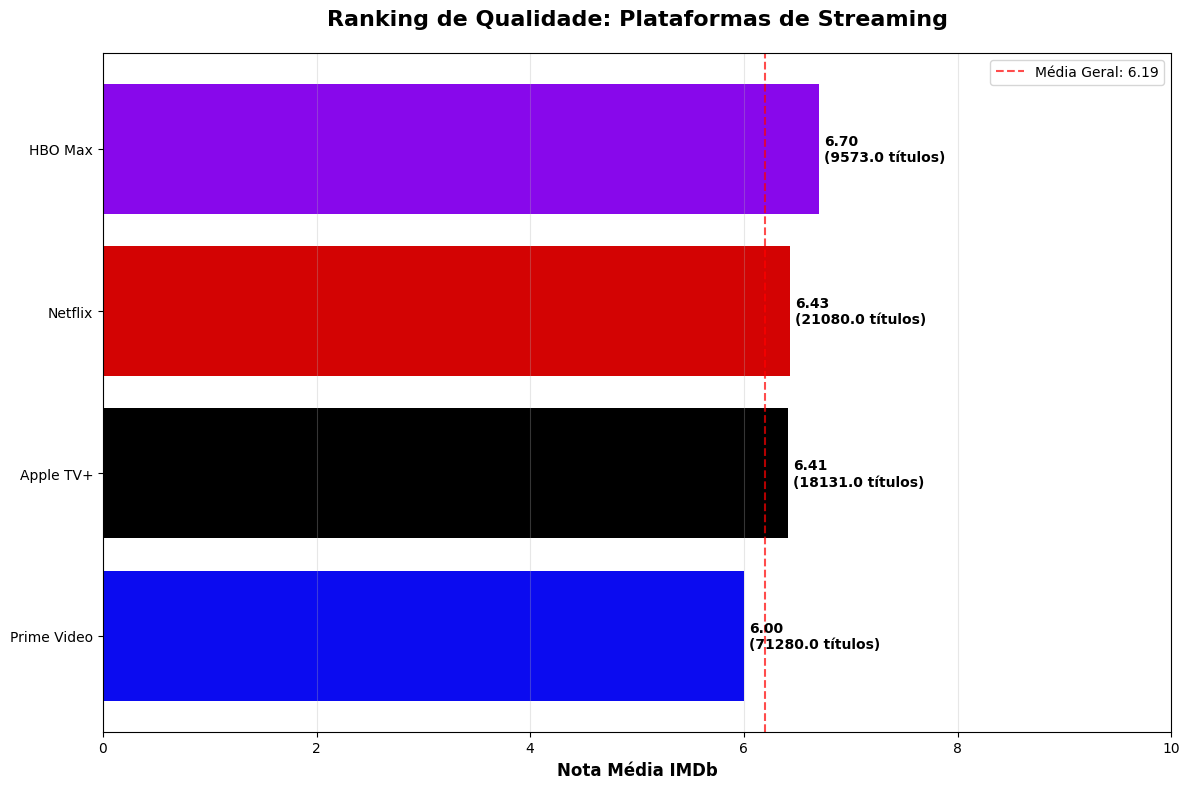

In [49]:
# Agrupar e preparar dados
quality_data = (
    df_streaming.groupby('platform')
    .agg(avg_rating=('imdbAverageRating', 'mean'),
         total_titles=('title', 'count'))
    .round(2)
    .sort_values('avg_rating')
)

# Visualização
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(quality_data.index, quality_data['avg_rating'],
               color=["#0B0BF0", "#000000", "#D30303", "#8808EB"])

for i, (platform, row) in enumerate(quality_data.iterrows()):
    ax.text(row['avg_rating'] + 0.05, i,
            f"{row['avg_rating']:.2f}\n({row['total_titles']} títulos)",
            va='center', fontweight='bold', fontsize=10)

overall_avg = df_streaming['imdbAverageRating'].mean()
ax.axvline(overall_avg, color='red', linestyle='--', alpha=0.7,
           label=f'Média Geral: {overall_avg:.2f}')

ax.set_xlabel('Nota Média IMDb', fontsize=12, fontweight='bold')
ax.set_title('Ranking de Qualidade: Plataformas de Streaming',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlim(0, 10)
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Como funciona a análise e visualização do perfil de gêneros por plataforma

Para entender o foco de cada plataforma de streaming nos principais gêneros cinematográficos, o notebook utiliza duas funções principais: `analyze_genre_focus` e `plot_radar_genre`. Veja como elas se conectam para gerar o gráfico de radar:

---

#### 1. **analyze_genre_focus**

Esta função recebe o DataFrame consolidado de todas as plataformas (`df_streaming`) e calcula, para cada plataforma, o percentual de títulos que pertencem a cada gênero principal (como Drama, Comédia, Ação, etc.).

- **O que ela faz?**
    - Para cada gênero, identifica os títulos que o possuem.
    - Conta quantos títulos de cada plataforma pertencem a esse gênero.
    - Calcula o percentual em relação ao total de títulos daquela plataforma.
    - Retorna uma matriz (DataFrame) onde as linhas são as plataformas e as colunas são os gêneros, com valores percentuais.

- **Exemplo de saída:**

    | Plataforma   | Drama | Comedy | Action | ... |
    |--------------|-------|--------|--------|-----|
    | Netflix      | 42.1  | 28.3   | 15.7   | ... |
    | HBO Max      | 38.5  | 25.0   | 12.0   | ... |
    | ...          | ...   | ...    | ...    | ... |

---

#### 2. **plot_radar_genre**

Esta função recebe a matriz gerada por `analyze_genre_focus` e cria gráficos de radar (um para cada plataforma), mostrando visualmente o perfil de gêneros de cada serviço.

- **O que ela faz?**
    - Seleciona os principais gêneros para o radar.
    - Para cada plataforma, plota um gráfico de radar com os percentuais de cada gênero.
    - Permite comparar rapidamente quais gêneros são mais ou menos representados em cada catálogo.

---

#### **Relação entre as funções**

- **Fluxo de dados:**  
  `analyze_genre_focus(df_streaming)` → gera a matriz de percentuais →  
  `plot_radar_genre(genre_focus_matrix)` → plota o gráfico de radar.

- **Resumo:**  
  A primeira função prepara os dados de gênero, a segunda transforma esses dados em uma visualização clara e comparativa.

---

#### **Visualização final: Gráfico de Radar**

O gráfico de radar resultante permite identificar rapidamente, por exemplo, se uma plataforma tem forte presença em "Drama" ou "Ação", ou se aposta mais em "Comédia" ou "Documentário", facilitando a análise estratégica do catálogo de cada serviço de streaming.

In [50]:
# Análise de gêneros dominantes por plataforma
def analyze_genre_focus(df, genres_list=['Drama', 'Comedy', 'Action', 'Horror', 'Romance', 
                  'Thriller', 'Documentary', 'Animation', 'Crime', 'Adventure']):
    genre_analysis = {}
    for genre in genres_list:
        genre_mask = df['genres'].str.contains(genre, case=False, na=False)
        genre_counts = df[genre_mask]['platform'].value_counts()
        genre_percentages = (genre_counts / df['platform'].value_counts() * 100).round(1)
        genre_analysis[genre] = genre_percentages
    return pd.DataFrame(genre_analysis).fillna(0)

genre_focus_matrix = analyze_genre_focus(df_streaming)


In [51]:

display(analyze_genre_focus(df_streaming))

,Drama,Comedy,Action,Horror,Romance,Thriller,Documentary,Animation,Crime,Adventure
platform,,,,,,,,,,
Apple TV+,45.4,25.4,11.5,9.6,14.7,11.9,13.4,3.0,14.4,6.8
HBO Max,36.1,25.6,11.7,4.7,9.2,7.9,20.5,9.6,13.2,12.0
Netflix,46.6,35.5,16.6,6.1,14.4,9.9,10.7,10.2,14.6,11.9
Prime Video,41.9,24.0,14.6,11.3,10.7,12.6,13.3,5.6,11.1,8.8


In [62]:
def plot_radar_genre(genre_focus):
    """4 radares limpos com código mínimo"""
    genres = ['Drama', 'Comedy', 'Action', 'Horror', 'Romance', 'Thriller']
    angles = np.linspace(0, 2*np.pi, len(genres), endpoint=False).tolist() + [0]
    colors = ['#000000', '#9146FF', '#E50914', '#00A8E1']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw=dict(projection='polar'))
    
    for i, (platform, ax) in enumerate(zip(genre_focus.index, axes.flat)):
        values = genre_focus.loc[platform, genres].tolist() + [genre_focus.loc[platform, genres].iloc[0]]
        
        ax.plot(angles, values, 'o-', linewidth=3, color=colors[i])
        ax.fill(angles, values, alpha=0.3, color=colors[i])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(genres, fontsize=10)
        ax.set_title(platform, fontsize=14, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Perfil de Gêneros por Plataforma', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


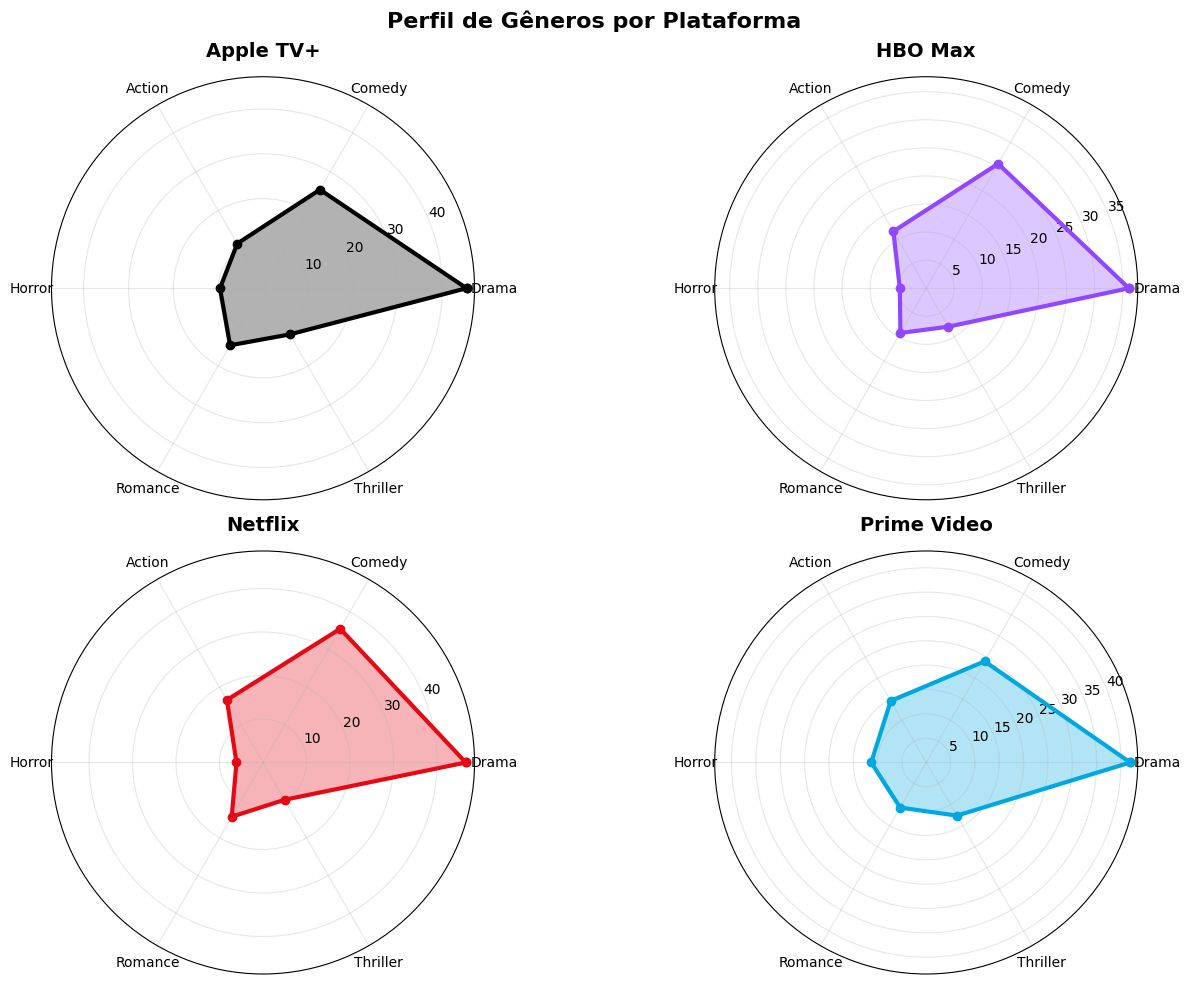

In [63]:
# Plotar radar de gêneros
plot_radar_genre(genre_focus_matrix)

**Aqui temos uma visualização de heatmap mostrando o percentual de títulos de cada plataforma que pertencem a cada gênero principal, permitindo comparar rapidamente o foco de catálogo entre os serviços de streaming.**

---

**Como funciona:**

- O DataFrame consolidado `df_streaming` reúne todos os títulos das plataformas, já identificados pela coluna `platform`.
- A função `analyze_genre_focus(df_streaming)` calcula, para cada plataforma, o percentual de títulos em cada gênero (Drama, Comédia, Ação, etc.), retornando a matriz `genre_focus_matrix`.
- O heatmap é criado com o Seaborn, usando essa matriz:
    - **Linhas:** plataformas
    - **Colunas:** gêneros
    - **Cores:** intensidade proporcional ao percentual de títulos naquele gênero

---

**Como ler o gráfico:**

- Cada célula mostra o percentual (%) de títulos daquela plataforma que pertencem ao gênero.
- Cores mais quentes (vermelho/laranja) indicam maior concentração.
- *Exemplo:*  
    Se "Netflix x Drama" mostra **46.6**, significa que **46,6% dos títulos da Netflix são classificados como Drama**.

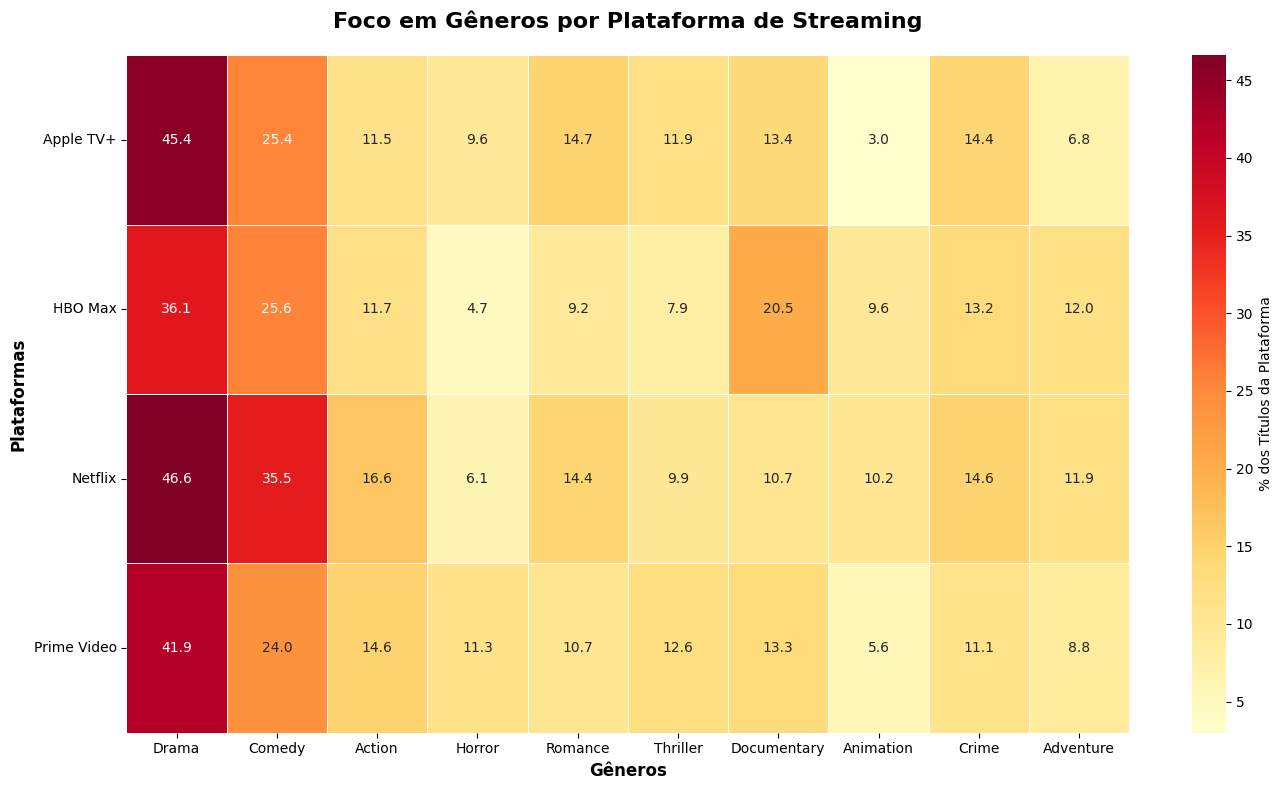

In [54]:
# Visualização
fig, ax = plt.subplots(figsize=(14, 8))

# Heatmap com anotações usando genre_focus_matrix (já criado pela função analyze_genre_focus)
sns.heatmap(genre_focus_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': '% dos Títulos da Plataforma'},
            linewidths=0.5, ax=ax)

ax.set_title('Foco em Gêneros por Plataforma de Streaming', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Gêneros', fontsize=12, fontweight='bold')
ax.set_ylabel('Plataformas', fontsize=12, fontweight='bold')

# Rotacionar labels para melhor leitura
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Gráfico de Exclusividade dos top 50 títulos 

O gráfico de exclusividade dos top 50 títulos mais votados utiliza diretamente o DataFrame unificado `df_streaming`, criado e tratado nas etapas anteriores do notebook. O processo segue estes passos:

- **Seleção dos Top 50:**
    - Usa `nlargest(50, 'imdbNumVotes')` para pegar os 50 títulos mais votados do catálogo consolidado.

- **Cálculo de Exclusividade:**
    - Agrupa os dados por título e conta em quantas plataformas cada um está disponível (`nunique()` sobre a coluna `platform`).

- **Preparação para o Gráfico:**
    - Faz um `merge` para associar cada título ao número de plataformas.
    - Agrupa para contar quantos títulos são:
        - Exclusivos (apenas 1 plataforma)
        - Compartilhados (2, 3 ou 4 plataformas)

- **Visualização:**
    - Utiliza Matplotlib para criar um gráfico de pizza, mostrando a proporção de títulos exclusivos versus compartilhados.

---

#### **Essa visualização:**

- Mostra a competição entre plataformas:
    - Revela quantos dos títulos mais populares são exclusivos, evidenciando estratégias de diferenciação.
- Ajuda na tomada de decisão:
    - Profissionais podem avaliar o peso da exclusividade no catálogo.
- Facilita a comparação:
    - Visualiza rapidamente o grau de compartilhamento de conteúdo entre os serviços.

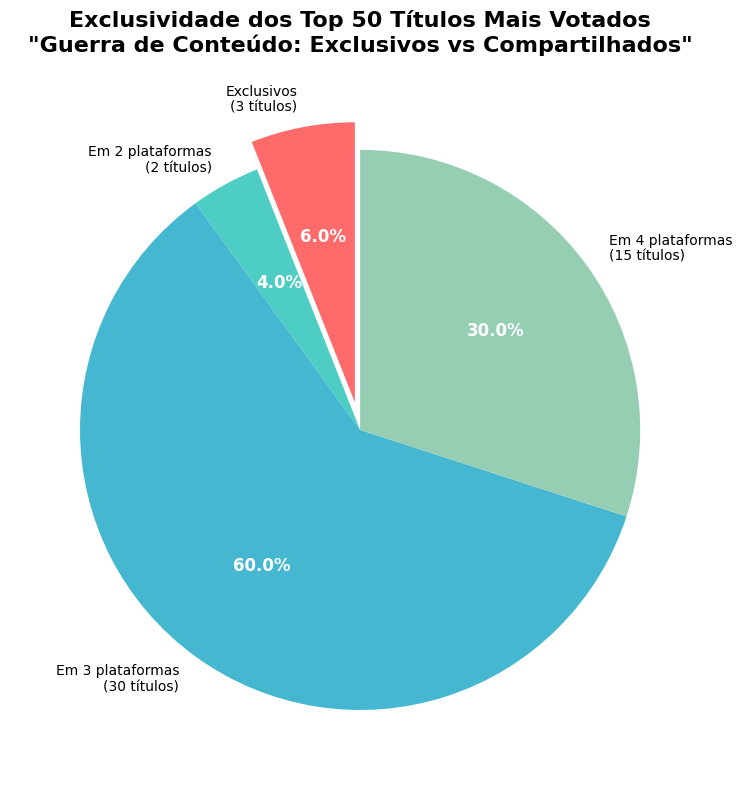

In [55]:
# Exclusividade dos top 50 títulos mais votados
top50 = df_streaming.nlargest(50, 'imdbNumVotes')
exclusivity = (
    top50.merge(
        df_streaming.groupby('title')['platform'].nunique().rename('num_platforms'),
        on='title'
    )
    .groupby('num_platforms')['title'].count()
    .sort_index()
)

labels = [
    f'Exclusivos\n({exclusivity.get(1,0)} títulos)' if n == 1 else f'Em {n} plataformas\n({c} títulos)'
    for n, c in exclusivity.items()
]
sizes = exclusivity.values
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig, ax = plt.subplots(figsize=(12, 8))
wedges, texts, autotexts = ax.pie(
    sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90,
    explode=[0.1 if n == 1 else 0 for n in exclusivity.index]
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

ax.set_title('Exclusividade dos Top 50 Títulos Mais Votados\n"Guerra de Conteúdo: Exclusivos vs Compartilhados"',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [64]:

# Seleciona os 50 títulos mais votados
top50 = df_streaming.nlargest(50, 'imdbNumVotes')

# Conta em quantas plataformas cada título está disponível
num_platforms = top50.groupby('title')['platform'].nunique()

# Conta quantos são exclusivos (apenas 1 plataforma)
exclusivos = (num_platforms == 1).sum()
compartilhados = (num_platforms > 1).sum()

print(f"Entre os 50 títulos mais votados:")
print(f"- Exclusivos de uma plataforma: {exclusivos} ({exclusivos/50:.0%})")
print(f"- Presentes em mais de uma plataforma: {compartilhados} ({compartilhados/50:.0%})")

Entre os 50 títulos mais votados:
- Exclusivos de uma plataforma: 3 (6%)
- Presentes em mais de uma plataforma: 15 (30%)


---

### Gráfico de Estratégia Temporal

A análise de **estratégia temporal** busca entender como cada plataforma de streaming equilibra seu catálogo entre títulos clássicos (mais antigos), lançamentos (recentes) e títulos de catálogo intermediário. Isso revela se o serviço aposta mais em novidades, em acervo histórico ou em um mix dos dois, o que é fundamental para compreender o posicionamento e a proposta de valor de cada plataforma.

---

#### 1. Função `categorize_strategy`

- **Finalidade:**  
  Classifica cada título do DataFrame consolidado (`df_streaming`) em três categorias estratégicas:
  - **Clássico:** Títulos lançados há mais de 20 anos.
  - **Lançamento:** Títulos lançados nos últimos 5 anos.
  - **Neutro:** Títulos que não se encaixam nas categorias acima ou possuem dados ausentes.

- **Funcionamento:**  
  - Para cada linha do DataFrame, avalia o ano de lançamento e a nota IMDb.
  - Cria uma nova coluna `category` com a classificação estratégica.
  - Agrupa os dados por plataforma e categoria, calculando o percentual de cada tipo no catálogo de cada serviço.
  - Retorna uma matriz de percentuais, pronta para visualização.

---

#### 2. Função `plot_bars_strategy`

- **Finalidade:**  
  Gera um gráfico de barras comparando, para cada plataforma, o percentual de títulos classificados como "Clássico" e "Lançamento".

- **Funcionamento:**  
  - Recebe a matriz de percentuais produzida por `categorize_strategy`.
  - Plota barras lado a lado para cada plataforma, destacando visualmente a proporção de clássicos e lançamentos.
  - Permite identificar rapidamente diferenças de estratégia entre os serviços.

---

#### **Relevância da Estratégia Temporal**

- **Por que é importante?**  
  - Mostra se a plataforma investe mais em novidades ou em acervo histórico.
  - Ajuda a entender o perfil do público-alvo de cada serviço.
  - Evidencia estratégias de diferenciação no mercado de streaming.

In [56]:
def categorize_strategy(df_streaming, classic_years=20, recent_years=5):
    """
    Função simples: ano + avaliação = categoria estratégica
    """
    current_year = 2024
    
    def get_category(year, rating):
        if pd.isna(year) or pd.isna(rating):
            return 'Neutro'
        
        if year <= (current_year - classic_years):
            return 'Clássico'
        elif year >= (current_year - recent_years):
            return 'Lançamento'
        else:
            return 'Neutro'
    
    # Aplicar categorização
    df_streaming['category'] = df_streaming.apply(
        lambda row: get_category(row['releaseYear'], row['imdbAverageRating']), axis=1
    )
    
    # Calcular percentuais por plataforma
    result = df_streaming.groupby(['platform', 'category']).size().unstack(fill_value=0)
    result_pct = result.div(result.sum(axis=1), axis=0) * 100
    
    return result_pct

In [57]:
def plot_bars_strategy(strategy_data):
    # Função para plotar gráfico de barras
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Dados para as barras
    platforms = strategy_data.index
    classics = strategy_data['Clássico']
    launches = strategy_data['Lançamento']
    
    x = np.arange(len(platforms))
    width = 0.35
    
    # Barras
    bars1 = ax.bar(x - width/2, classics, width, label='Clássicos', 
                   color="#113BC5", alpha=0.8)
    bars2 = ax.bar(x + width/2, launches, width, label='Lançamentos', 
                   color="#0FCBF5", alpha=0.8)
    
    # Valores nas barras
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax.set_xlabel('Plataformas', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentual do Catálogo (%)', fontsize=12, fontweight='bold')
    ax.set_title('Estratégia Temporal: Clássicos vs Lançamentos', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(platforms)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

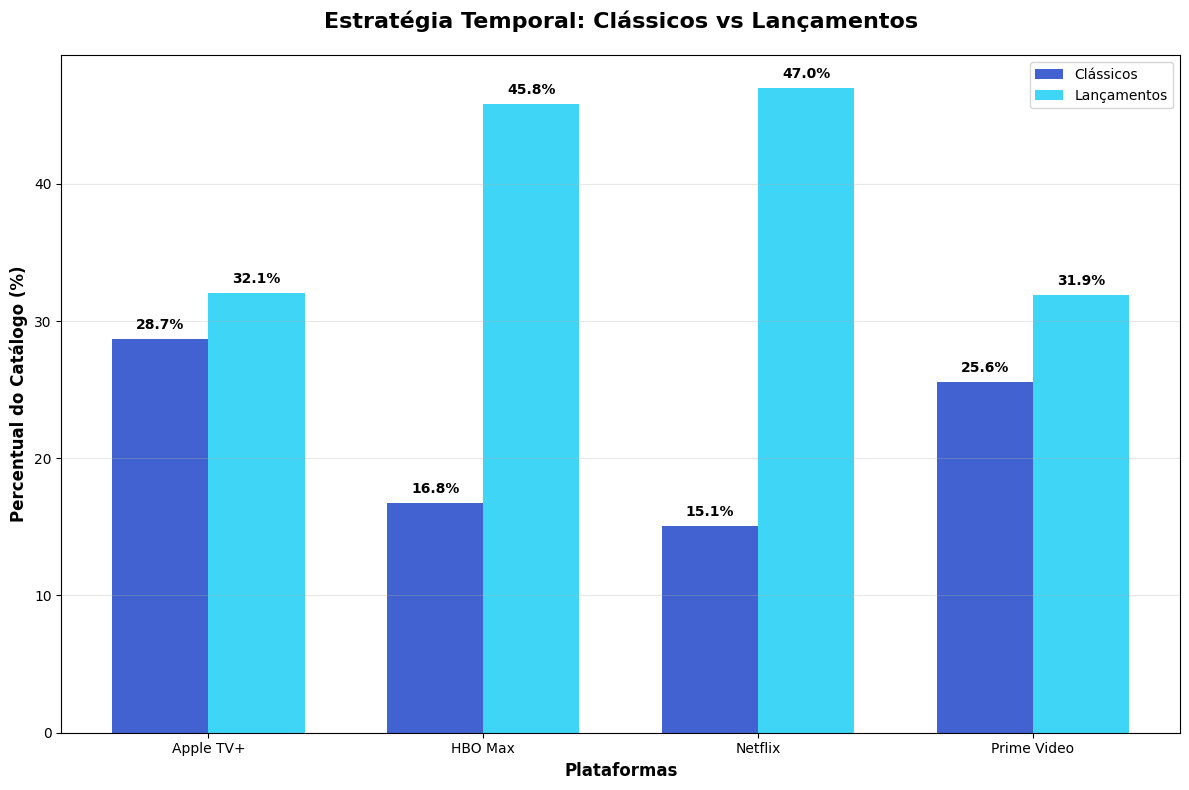

category,Clássico,Lançamento,Neutro
platform,,,
Apple TV+,28.7,32.1,39.2
HBO Max,16.8,45.8,37.4
Netflix,15.1,47.0,37.9
Prime Video,25.6,31.9,42.5


In [58]:
# Usando a função para categorizar e plotar
strategy_pct = categorize_strategy(df_streaming)
plot_bars_strategy(strategy_pct)
display(strategy_pct.round(1))  

- **O que faz a função `plot_distribution_histogram`:**  
    Plota um histograma empilhado mostrando como as notas dos filmes (IMDb) estão distribuídas entre as quatro plataformas de streaming analisadas.

---

**Funcionamento Resumido:**

- **Entrada:**  
    - DataFrame consolidado (`df_streaming`) com as colunas `platform` e `imdbAverageRating`.

- **Processo:**  
    - Filtra e remove valores ausentes dessas colunas.
    - Separa as notas de cada plataforma.
    - Define intervalos de notas (bins) de 0.5 em 0.5, de 1 a 10.
    - Plota um histograma empilhado, onde cada cor representa uma plataforma.
    - Adiciona rótulos, título, legenda e grade para facilitar a leitura.

- **Saída:**  
    - Um gráfico visualizando, lado a lado, quantos filmes de cada plataforma estão em cada faixa de nota.

> 💡 **Resumo visual:**  
> O histograma facilita a comparação direta da distribuição de qualidade dos catálogos das plataformas, destacando diferenças de estratégia (volume vs. curadoria).


In [59]:
def plot_distribution_histogram(df_streaming):
    """Histograma mostra quantos filmes em cada faixa de nota"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    df_clean = df_streaming[['platform', 'imdbAverageRating']].dropna()
    
    # Criar bins para as notas
    bins = np.arange(1, 11, 0.5)  # Bins de 0.5 em 0.5
    
    # Dados por plataforma
    netflix_data = df_clean[df_clean['platform'] == 'Netflix']['imdbAverageRating']
    hbo_data = df_clean[df_clean['platform'] == 'HBO Max']['imdbAverageRating']
    apple_data = df_clean[df_clean['platform'] == 'Apple TV+']['imdbAverageRating']
    prime_data = df_clean[df_clean['platform'] == 'Prime Video']['imdbAverageRating']
    
    # Histograma empilhado
    ax.hist([netflix_data, hbo_data, apple_data, prime_data], 
            bins=bins, alpha=0.8, 
            label=['Netflix', 'HBO Max', 'Apple TV+', 'Prime Video'],
            color=['#E50914', '#9146FF', '#000000', '#00A8E1'])
    
    ax.set_xlabel('Nota IMDb', fontsize=12, fontweight='bold')
    ax.set_ylabel('Número de Filmes', fontsize=12, fontweight='bold')
    ax.set_title('Distribuição por Faixas de Nota\nQuantos filmes cada plataforma tem em cada nota', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


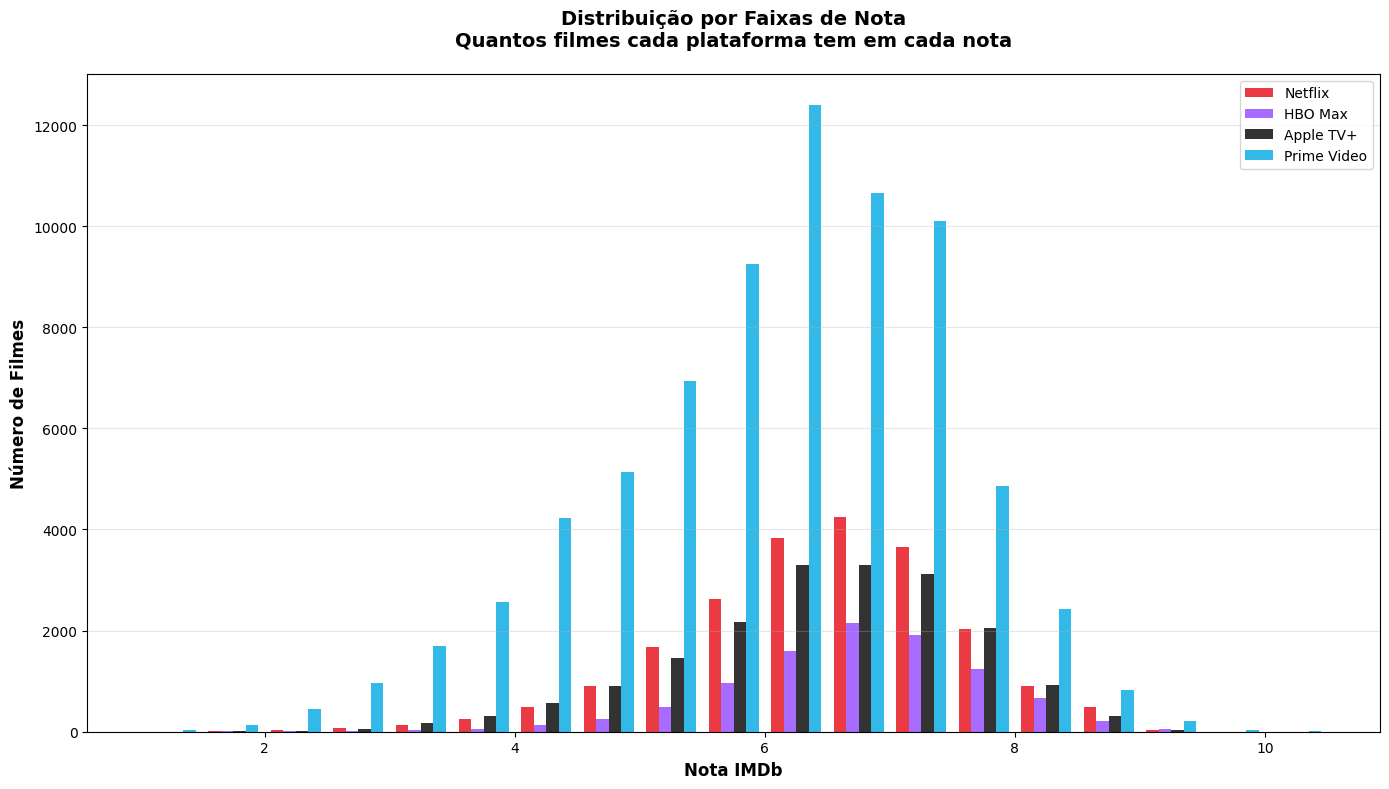

In [60]:
#usando a função plot_distribution_histogram
plot_distribution_histogram(df_streaming)

---

### Prime Video (Estratégia de Volume)

- **72.943 títulos** (59,4% do dataset total)
    - Muitos filmes na faixa **6.0-7.0** (bem avaliados, mas não excepcionais)
    - Poucos filmes realmente ruins (**abaixo de 5.0**)
    - Poucos filmes excepcionais (**acima de 8.0**)
    - Resultado: Média "puxada para baixo" pelo volume de conteúdo mediano
---

### HBO Max (Estratégia Boutique)

- **9.776 títulos** (apenas 8% do dataset)
    - Curadoria mais seletiva
    - Menos volume, mas maior concentração de títulos de qualidade superior
    - Resultado: Média mais alta
---

### Analogia Simples

- É como comparar:
    - **Supermercado (Prime Video):**
        - Tem de tudo, muita coisa boa, algumas ruins, média geral OK
        - Aposta na abundância: "temos algo para todo mundo"
    - **Delicatessen (HBO Max):**
        - Só produtos selecionados, média de qualidade mais alta
        - Aposta na exclusividade: "temos o melhor conteúdo"
- Ambas as estratégias funcionam, mas para públicos diferentes:
    - Prime Video satisfaz quem quer variedade
    - HBO Max satisfaz quem quer qualidade premium

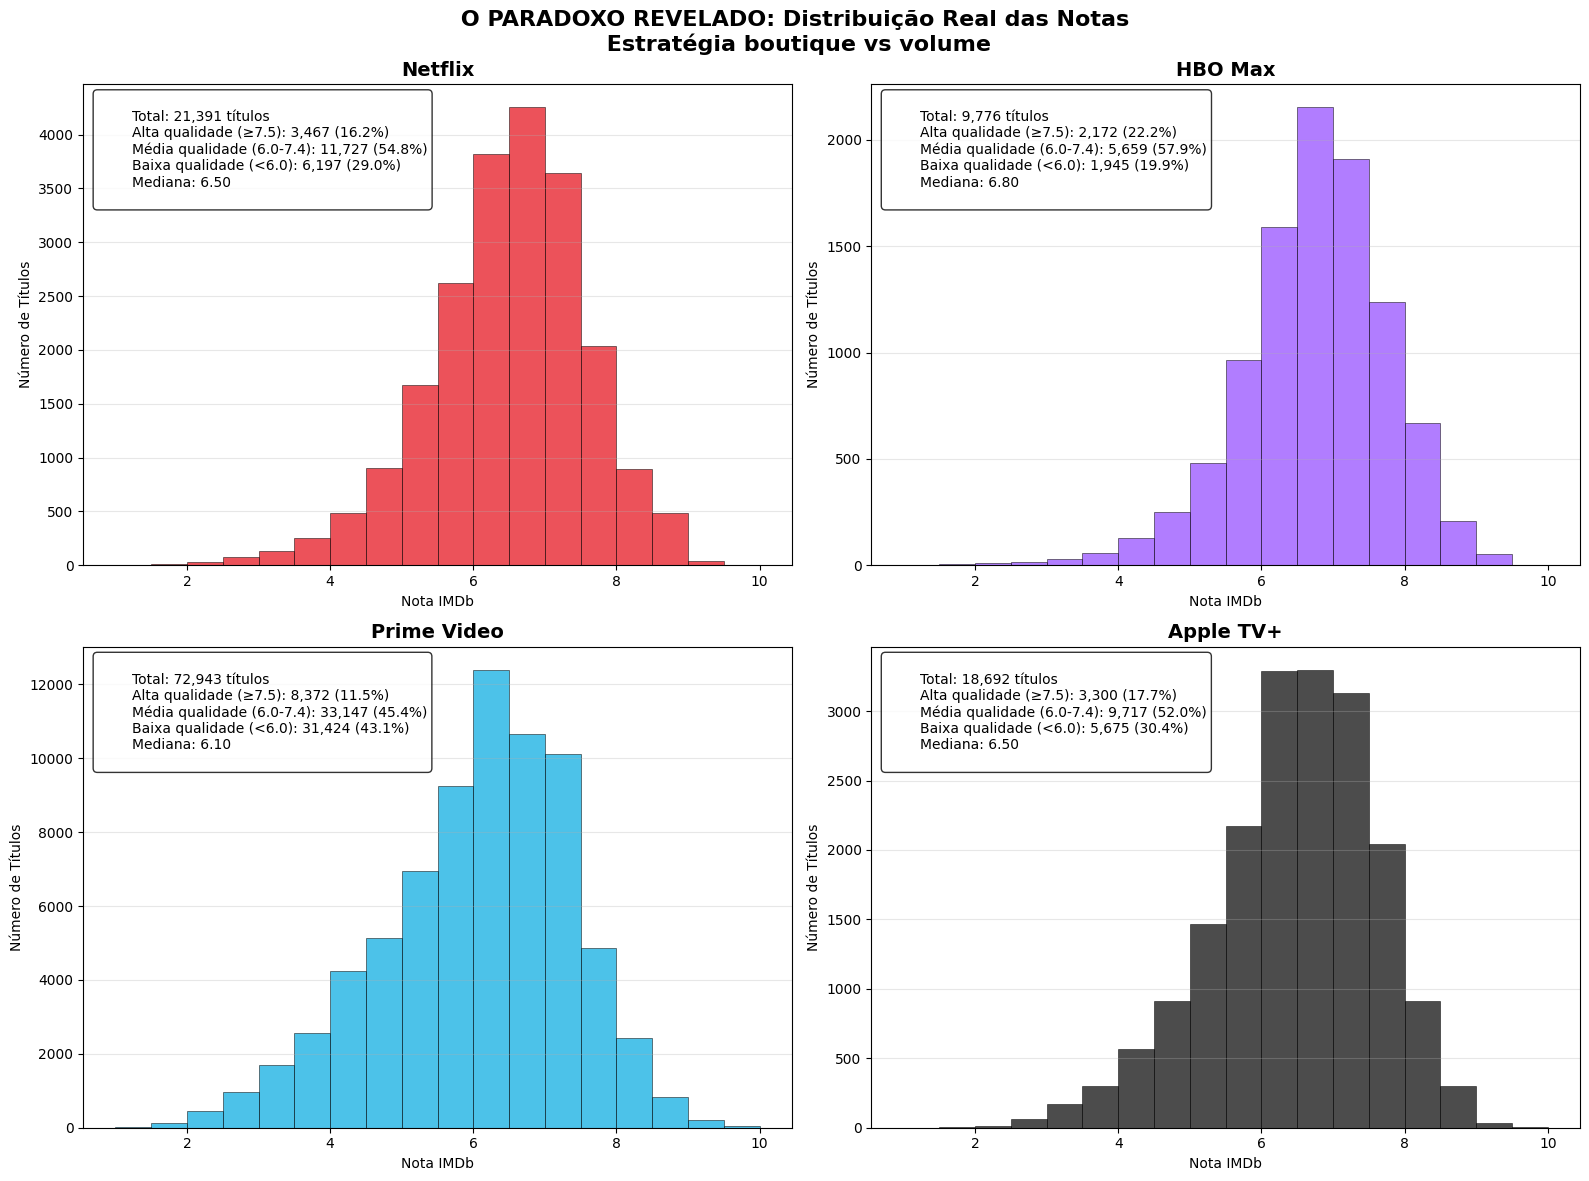

In [67]:
def plot_quality_distribution_comparison_complete(df_streaming):
    """Mostra COMO cada plataforma distribui suas notas - TODAS as 4 plataformas"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    platforms = ['Netflix', 'HBO Max', 'Prime Video', 'Apple TV+']  # Todas as 4!
    colors = ['#E50914', '#9146FF', '#00A8E1', '#000000']
    
    # Criar bins de qualidade
    bins = np.arange(1, 10.5, 0.5)
    
    for i, platform in enumerate(platforms):
        ax = axes[i//2, i%2]
        data = df_streaming[df_streaming['platform'] == platform]['imdbAverageRating'].dropna()
        
        # Histograma
        counts, _, _ = ax.hist(data, bins=bins, alpha=0.7, color=colors[i], 
                              edgecolor='black', linewidth=0.5)
        
        # Estatísticas importantes
        total = len(data)
        high_quality = len(data[data >= 7.5])
        medium_quality = len(data[(data >= 6.0) & (data < 7.5)])
        low_quality = len(data[data < 6.0])
        
        # Adicionar texto explicativo
        stats_text = f"""
        Total: {total:,} títulos
        Alta qualidade (≥7.5): {high_quality:,} ({high_quality/total*100:.1f}%)
        Média qualidade (6.0-7.4): {medium_quality:,} ({medium_quality/total*100:.1f}%)
        Baixa qualidade (<6.0): {low_quality:,} ({low_quality/total*100:.1f}%)
        Mediana: {data.median():.2f}
        """
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        ax.set_title(f'{platform}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Nota IMDb')
        ax.set_ylabel('Número de Títulos')
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle(' O PARADOXO REVELADO: Distribuição Real das Notas \n Estratégia boutique vs volume', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Executar
plot_quality_distribution_comparison_complete(df_streaming)


## SINTETIZANDO OS INSIGTHS DOS DOIS GRÁFICOS

---

## Comparação Visual das Estratégias das Plataformas de Streaming

### 1. **Histograma Geral: plot_distribution_histogram**

O histograma empilhado mostra, em um único gráfico, como as notas dos filmes estão distribuídas entre as quatro plataformas. Ele permite ver rapidamente:

- **Prime Video** domina em volume, com muitos títulos na faixa 6.0–7.0.
- **HBO Max** tem menos títulos, mas maior proporção de notas altas.
- **Netflix** e **Apple TV+** ficam em posições intermediárias, com perfis próprios.

---

### 2. **Análise Detalhada: plot_quality_distribution_comparison_complete**

A função aprofunda a análise ao mostrar **um histograma separado para cada plataforma**, incluindo estatísticas como:

- Total de títulos
- Percentual de filmes de alta, média e baixa qualidade
- Mediana das notas

Isso evidencia claramente a **estratégia de cada empresa**:

- **Prime Video:**  
  - **Estratégia de volume**  
  - Maior catálogo, maioria dos títulos com notas medianas (6.0–7.0)
  - Poucos títulos excepcionais ou muito ruins

- **HBO Max:**  
  - **Estratégia boutique/curadoria**  
  - Menos títulos, mas maior concentração de filmes bem avaliados (alta qualidade)
  - Mediana de notas mais alta

- **Netflix:**  
  - **Estratégia híbrida**  
  - Grande volume, mas com distribuição mais equilibrada entre faixas de nota
  - Mistura títulos medianos e alguns de alta qualidade

- **Apple TV+:**  
  - **Catálogo enxuto e curado**  
  - Poucos títulos, mas foco em qualidade e exclusividade
  - Perfil semelhante ao da HBO Max, mas com ainda menos volume

---

### **Resumo Visual das Estratégias**

- **Prime Video:** Supermercado — aposta na variedade e quantidade.
- **HBO Max:** Delicatessen — aposta na curadoria e qualidade premium.
- **Netflix:** Mix entre volume e curadoria, buscando atender a todos os públicos.
- **Apple TV+:** Boutique exclusiva — poucos títulos, mas selecionados.

Essas visualizações deixam claro como cada empresa posiciona seu catálogo para conquistar diferentes perfis de público no mercado de streaming.

---

## Recomendações Estratégicas para Plataformas de Streaming

E se eu tivesse a chance de indicar estratégias de melhoria pras gigantes do entretenimento? Bem, com base no volume, qualidade, perfil de catálogo, exclusividade e estratégia temporal, seria algo assim:

---

### **Prime Video**
- **Curadoria e Destaque de Qualidade:**  
  Invista em mecanismos de recomendação e destaque para títulos de alta avaliação, evitando que o grande volume dilua a percepção de valor.
- **Facilite a Descoberta:**  
  Melhore filtros e buscas para ajudar o usuário a encontrar rapidamente conteúdos relevantes.
- **Aposte em Exclusivos:**  
  Considere aumentar o número de títulos exclusivos para diferenciar o catálogo.

---

### **HBO Max**
- **Expansão com Curadoria:**  
  Avalie ampliar o catálogo, mas mantendo o padrão de qualidade e curadoria.
- **Comunicação de Valor Premium:**  
  Destaque títulos premiados e exclusivos para reforçar o posicionamento de “delicatessen”.
- **Diversificação de Gêneros:**  
  Explore oportunidades em gêneros menos representados para atrair novos públicos.

---

### **Netflix**
- **Aprimore a Personalização:**  
  Invista em algoritmos de recomendação para equilibrar o grande volume com a entrega de conteúdo relevante.
- **Destaque para Títulos de Alta Qualidade:**  
  Crie selos ou campanhas para filmes e séries bem avaliados.
- **Mix de Lançamentos e Clássicos:**  
  Mantenha o equilíbrio entre novidades e acervo histórico para atender diferentes perfis.

---

### **Apple TV+**
- **Aumente Gradualmente o Catálogo:**  
  Amplie o portfólio sem perder o foco em qualidade e exclusividade.
- **Parcerias Estratégicas:**  
  Busque co-produções e acordos para trazer mais títulos exclusivos.
- **Reforce a Imagem de Boutique:**  
  Comunique prêmios e diferenciais dos títulos para consolidar o posicionamento premium.

---

### **Para Todas as Plataformas**
- **Transparência nas Avaliações:**  
  Exiba notas e avaliações de forma clara para ajudar na escolha do usuário.
- **Atenção à Diversidade de Gêneros:**  
  Monitore tendências e ajuste o catálogo conforme a demanda.
- **Estratégia Temporal:**  
  Equilibre lançamentos e clássicos para ampliar o apelo do catálogo.

---

Essas recomendações visam fortalecer o posicionamento de cada serviço, melhorar a experiência do usuário e aumentar a competitividade no mercado de streaming, sem perder de vista suas estratégias de negócio.

## 🎬 E assim termina nossa maratona de dados!

Se você chegou até aqui, parabéns: já pode pedir pipoca no RH e um troféu de DataFlix! 🍿🏆  
Espero que os gráficos tenham sido mais claros que final de série da HBO (e menos confusos que catálogo da Prime Video 😅).

Qualquer dúvida, é só dar um "play" de novo no notebook ou me pergunta lá no linkedin www.linkedin.com/in/denise-soares-data. 

Até a próxima análise — e lembre-se: dados são como séries boas, sempre vale uma segunda olhada!

**Fim** 🚀